In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
import numpy as np
from statsmodels.tsa.api import VAR, VARMAX


import utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1, should_scale=False, should_log=False)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False, should_scale=False, should_log=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12, should_scale=False, should_log=False)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=False, should_log=False)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))

/Users/Xavier/cdpq-ia/utils.py:224: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  autres = autres.apply(pd.to_numeric, errors="ignore")


In [2]:
def make_multivariate_time_series(ts, covariates, only_cpi=True):
    if only_cpi:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates["US_CPI"])
    else:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates)

    # Split the data into training and validation sets
    train_ts_scaled, val_ts_scaled = ts_multivariate.split_after(pd.Timestamp("2016-01-01"))

    # Reconvert to DataFrame since statsmodels does not support TimeSeries objects
    train = train_ts_scaled.pd_dataframe()
    validation = val_ts_scaled.pd_dataframe()
    history = pd.concat([train, validation])

    return train, validation, history


train, validation, history = make_multivariate_time_series(ts_scaled, covariates_scaled, only_cpi=False)

In [19]:
train.head()

KeyError: "['INTDSRUSM193N'] not found in axis"

# VAR Model

<Axes: xlabel='DATE'>

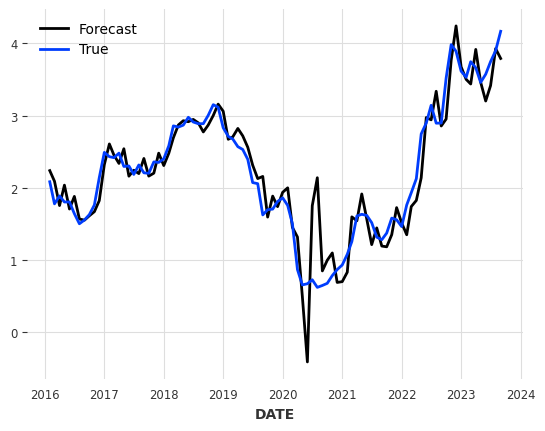

In [4]:
# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

    # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month
    model = VAR(hist_t)
    model_fit = model.fit(maxlags=1)

    # Forecast for t + 1
    y_pred = model_fit.forecast(hist_t.values[-model_fit.k_ar:], steps=1)[0][0]
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_times_and_values(values=np.array([y_pred]), times=pd.DatetimeIndex([t], freq="ME")), pipeline, ts_scaled["US_TB_YIELD_10YRS"])
    y_pred_unscaled = y_pred_unscaled.pd_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})



    # print(y_pred.summary_frame())
    forecasts = pd.concat([forecasts, y_pred_unscaled])

# Revert the scaling
fore_unscaled = TimeSeries.from_dataframe(forecasts, value_cols=["mean"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

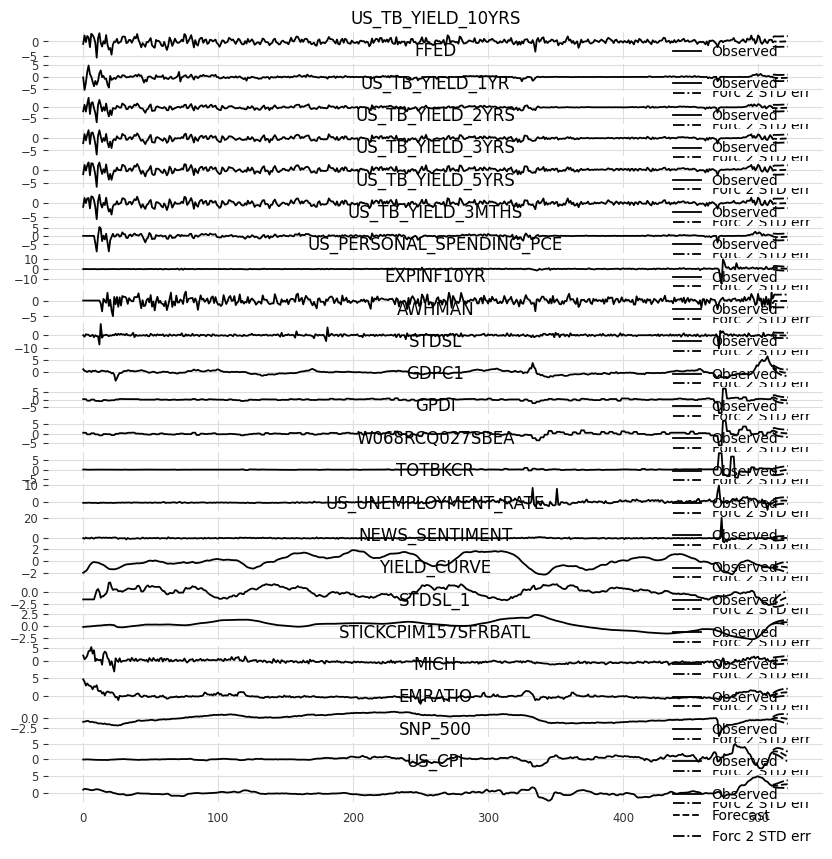

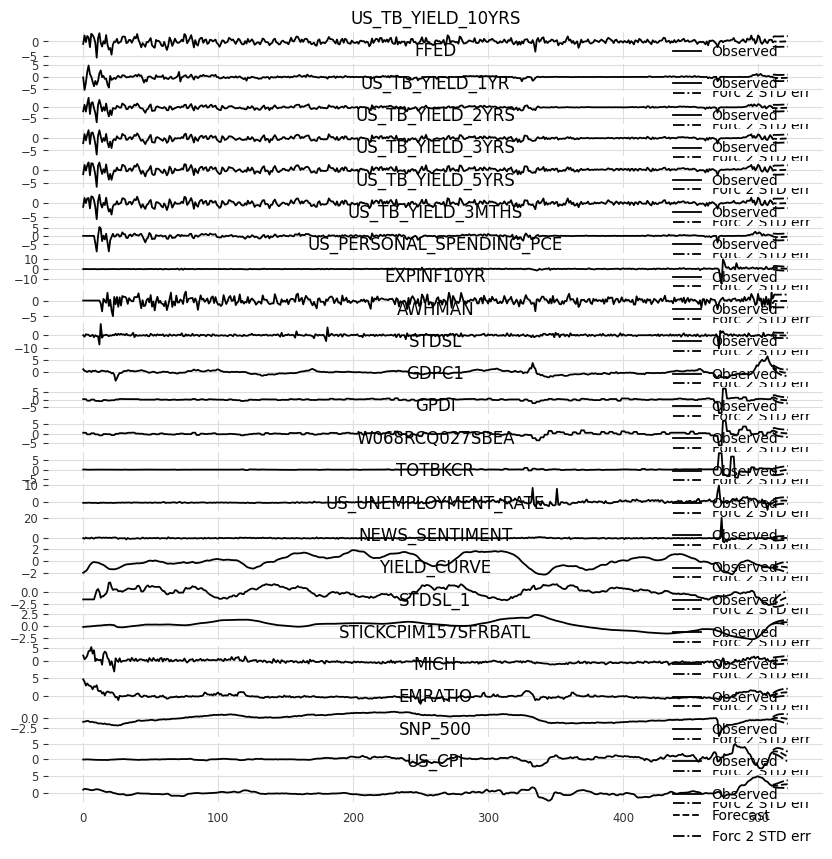

In [5]:
model_fit.plot_forecast(steps=12)

In [6]:
test_result = model_fit.test_causality(caused='US_TB_YIELD_10YRS', causing=['US_CPI'], kind='f', signif=0.05)
test_result.summary()

Test statistic,Critical value,p-value,df
0.4053,3.842,0.524,"(1, 11640)"


In [7]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Jan, 2025
Time:                     15:22:51
--------------------------------------------------------------------
No. of Equations:         24.0000    BIC:                   -83.3297
Nobs:                     510.000    HQIC:                  -86.3582
Log likelihood:           5751.59    FPE:                4.44312e-39
AIC:                     -88.3113    Det(Omega_mle):     1.40875e-39
--------------------------------------------------------------------
Results for equation US_TB_YIELD_10YRS
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.002620         0.038810           -0.068           0.946
L1.US_TB_YIELD_10YRS                0.002944         0.218967            0.013         

In [8]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 15.523299854450144
RMSE: 0.311381944257339
R2: 0.87550193795543


In [9]:
norm = model_fit.test_normality()
norm.summary()

Test statistic,Critical value,p-value,df
2.815e+05,65.17,0.000,48


In [10]:
whiteness = model_fit.test_whiteness()
whiteness.summary()

Test statistic,Critical value,p-value,df
1.141e+04,5353.,0.000,5184


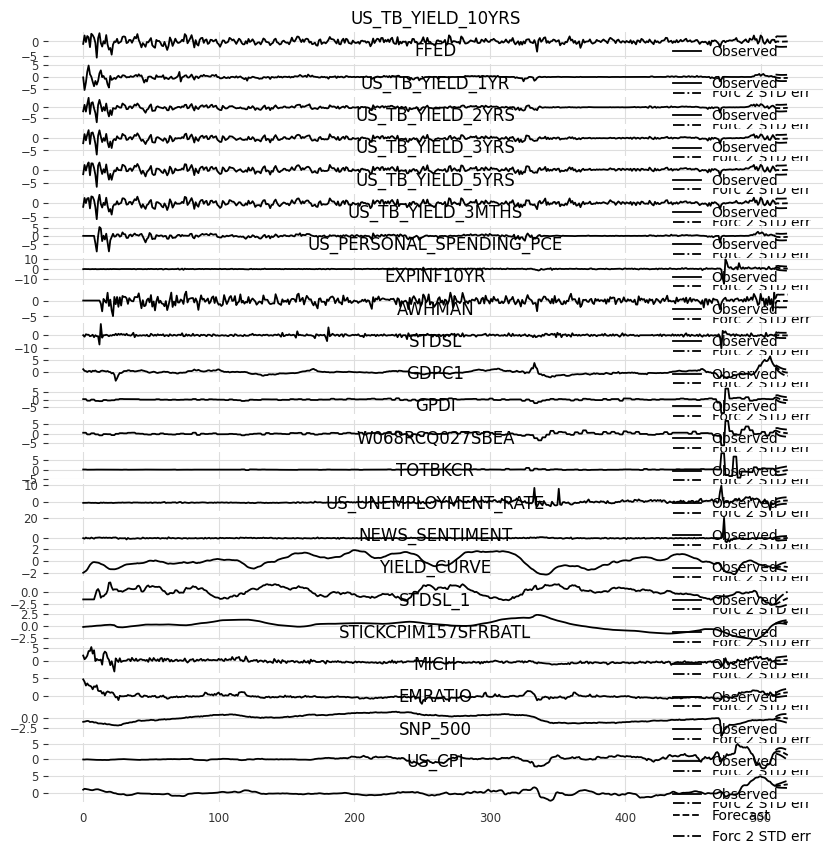

In [11]:
fig = model_fit.plot_forecast(10)

In [ ]:
from statsmodels.tsa.vector_ar.irf import IRAnalysis

t: IRAnalysis = model_fit.irf(10)

t.

AttributeError: 'IRAnalysis' object has no attribute 'svar_irfs'

In [18]:
import numpy as np
from statsmodels.tsa.api import SVAR
# Specify structural matrices
A = np.array([[1, 0, 0],
              ["E", 1, 0],
              ["E", "E", 1]])  # Contemporaneous restrictions

B = np.array([[1, 0, 0],
              [0, 1, 0],
              ["E", 0, 1]])  # Long-run restrictions (identity in this case)

# Fit the SVAR model
svar_model = SVAR(train, svar_type='AB', A=A, B=B)  # Use 'B' for long-run restrictions
svar_results = svar_model.fit(maxlags=3, maxiter=10000, maxfun=10000)

# Inspect results
svar_results.irf(periods=30).plot(impulse='real', plot_stderr=True,
                         stderr_type='mc', repl=100)

IndexError: index 9 is out of bounds for axis 0 with size 9